In [2]:
import urllib, json, time
import sys
import os
import errno
import zipfile
import subprocess
import logging
sys.path.append('/usr/local/lib/python2.7/dist-packages/')
import wget
import datetime

class Extent(object):

    min_x = 0
    min_y = 0
    max_x = 0
    max_y = 0

    def __init__(self, min_x, min_y, max_x, max_y):
        self.min_x = min_x
        self.min_y = min_y
        self.max_x = max_x
        self.max_y = max_y


    def __repr__(self):
        return "\nmin x = " + str(self.min_x) + "\nmin y = " + str(self.min_y) + "\nmax x = " + str(self.max_x)  + "\nmax y = " + str(self.max_y) + "\n"


class RHESSysWorkflow(object):
 

    ######################################
    ## Important variables for catchment(s)
    extent = Extent(0,0,0,0)
    
    ######################################
    ## Common variables for RHESSysWorkflow
    project_location = '/tmp'
    project_name = 'test'
    output_folder_location = project_location + "/" + project_name
    sub_project_folder = ''
    gageid = '01589312'
    publisher = 'Brian Miles <brian_miles@unc.edu>'
    
    lai_fullpathname_with_ext = ''
    climate_data_fullpathname =''
    station_data_fullpathname = ''
    dem_cell_threshold = 500
    areaEstimate = 1.5
    rhessys_source_location = ''
    model_start_year = 2000
    model_start_month = 1
    model_start_day = 1
    model_end_year = 2001
    model_end_month = 1
    model_end_day = 1


    ######################################
    ## Common variables for HydroTerre Workflows
    ht_start_date = '2000-01-01'
    ht_end_date = '2001-01-01'
    huc_list_as_string = 'NONE'
    huc_list_count = 0
    huc_list = []

    ######################################
    ## Variables for this tool
    start_time = datetime.datetime.now()
    end_time = datetime.datetime.now()
    timespan = end_time - start_time
    logger = ''
    hdlr = ''

    ###############################################################################################
    def __init__(self, project_location, project_name, gageid, start_date, end_date, rhessys_source_location, publisher):
        self.project_location = project_location
        self.project_name = project_name
        self.gageid = gageid
        self.ht_start_date = start_date
        self.ht_end_date = end_date
        self.output_folder_location = self.project_location + "/" + self.project_name
        self.sub_project_folder = self.output_folder_location + "/" + self.project_name
        self.rhessys_source_location = rhessys_source_location
        self.publisher = publisher
        self.filter_times()

        ######################################
        ## Create project location
        self.create_path(self.output_folder_location)
        self.create_path(self.sub_project_folder)
        self.setup_log()

        ######################################
        ## Create workflow
        print("Start Executing workflow")
        self.execute_workflow()
        print("End Executing workflow")



    ###############################################################################################
    ### Common functions to manage workflow

    def create_path(self, path):
        try:
            if not os.path.isdir(path):
                os.makedirs(path)
        except OSError as exception:
            if exception.errno != errno.EEXIST or not os.path.isdir(path):
                raise


    def setup_log(self):
        log_file = self.output_folder_location + "/" + self.project_name + ".log"
        print 'Log file location: ' + log_file
        self.logger = logging.getLogger("myApp")
        self.hdlr = logging.FileHandler(log_file)
        self.logger.addHandler(self.hdlr)
        self.logger.setLevel(logging.INFO)
 

    def unzip_etv_zip_file_at_path(self, input_location, etv_output_folder_location):
        try:
            zfile = zipfile.ZipFile(input_location)
            zfile.extractall(etv_output_folder_location)
            zfile.close()
        except Exception,e:
            print str(e)



    ###############################################################################################
    ### Functions to retrieve properties from RHESSysWorkflow

    def filter_times(self):
        start_split = self.ht_start_date.split('-')
        end_split = self.ht_end_date.split('-')

        self.model_start_year = int(start_split[0])
        self.model_start_month = int(start_split[1])
        self.model_start_day = int(start_split[2])
        self.model_end_year = int(end_split[0])
        self.model_end_month = int(end_split[1])
        self.model_end_day = int(end_split[2])

    def get_Metadata_filename(self):
        return self.project_location + "/" + self.project_name + "/" + self.project_name + "/metadata.txt"

    def get_Extent_from_RHESSysWorkflows_Metadata_File(self):

        try:
            metadata_file_and_path = self.get_Metadata_filename()       
            self.logger.info(metadata_file_and_path)

            extent_min_x = ''
            extent_max_x = ''
            extent_min_y = ''
            extent_max_y = ''

            f = open(metadata_file_and_path, 'r')
            lines = f.readlines()
            for line in lines:
                #print line
                fnd = line.find('bbox_wgs84 = ')
                if fnd == 0:
                    #print line
                    split1 = line.split(' = ') #BEWARE OF SPACES
                    split2 = split1[1].replace('\n','').split(' ')
                    #print split2
                    extent_min_x = split2[0]
                    extent_min_y = split2[1]
                    extent_max_x = split2[2]
                    extent_max_y = split2[3]


            result = Extent(extent_min_x,extent_min_y,extent_max_x,extent_max_y)
            self.logger.info(result)
            return result
        except Exception,e:
            self.logger.error(str(e))
            return -1


    ###############################################################################################
    ### Functions to execute RHESSysWorkflow

    def get_NHDStreamflowGageIdentifiersAndLocation(self, sub_project_folder, gageid):
        try:
            my_command = "GetNHDStreamflowGageIdentifiersAndLocation.py -p " + sub_project_folder + " -g " + gageid
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def get_CatchmentShapefileForNHDStreamflowGage(self, sub_project_folder):
        try:
            my_command = "GetCatchmentShapefileForNHDStreamflowGage.py --overwrite -p " + sub_project_folder
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def get_BoundingboxFromStudyareaShapefile(self, sub_project_folder):
        try:
            my_command = "GetBoundingboxFromStudyareaShapefile.py -p " + sub_project_folder
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except subprocess.CalledProcessError as e:
            self.logger.error(str(e))
            return -1
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def get_USGSDEMForBoundingbox(self, sub_project_folder):
        try:
            my_command = "GetUSGSDEMForBoundingbox.py -p " + sub_project_folder
            self.logger.info(my_command)

            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def get_USGSNLCDForDEMExtent(self, sub_project_folder):
        try:
            my_command = "GetUSGSNLCDForDEMExtent.py -p " + sub_project_folder
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def get_SSURGOFeaturesForBoundingbox(self, sub_project_folder):
        try:
            my_command = "GetSSURGOFeaturesForBoundingbox.py -p " + sub_project_folder
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def GenerateSoilPropertyRastersFromSSURGO(self, sub_project_folder):
        try:
            my_command = "GenerateSoilPropertyRastersFromSSURGO.py -p " + sub_project_folder
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1


    def Register_LAI_Raster(self, sub_project_folder, lai_fullpathname_with_ext, publisher):
        try:
            my_command = "RegisterRaster.py -p " + sub_project_folder + " -t lai -r " + lai_fullpathname_with_ext + " -b \"" + publisher + "\" --force "
            self.logger.info(my_command) 
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1


    def CreateGRASSLocationFromDEM(self, sub_project_folder, description):
        try:
            my_command = "CreateGRASSLocationFromDEM.py -p " + sub_project_folder + " -d " + description
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1


    def ImportRHESSysSource(self, sub_project_folder, source_code_location):
        try:
            my_command = "ImportRHESSysSource.py -p " + sub_project_folder + " -s " + source_code_location
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1


    def ImportClimateData(self, sub_project_folder, climate_data_location):
        try:
            my_command = "ImportClimateData.py -p " + sub_project_folder + " -s " + climate_data_location
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1


    def GenerateBaseStationMap(self, sub_project_folder, station_data_location):
        try:
            my_command = "GenerateBaseStationMap.py -p " + sub_project_folder + " -b " + station_data_location
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1


##TODO OTHER VARIABLES
    def DelineateWatershed(self, sub_project_folder, dem_cell_threshold, areaEstimate):
        try:
            my_command = "DelineateWatershed.py -p " + sub_project_folder + " -t " + str(dem_cell_threshold) + " -a " + str(areaEstimate)
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1


##TODO OTHER VARIABLES
    def GeneratePatchMap(self, sub_project_folder):
        try:
            my_command = "GeneratePatchMap.py -p " + sub_project_folder + " -t clump -c elevation"
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def GenerateSoilTextureMap(self, sub_project_folder):
        try:
            my_command = "GenerateSoilTextureMap.py -p " + sub_project_folder
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1


    def ImportRasterMapIntoGRASS_LAI(self, sub_project_folder):
        try:
            my_command = "ImportRasterMapIntoGRASS.py -p " + sub_project_folder + " -t lai -m nearest"
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def ImportRasterMapIntoGRASS_LANDCOVER(self, sub_project_folder):
        try:
            my_command = "ImportRasterMapIntoGRASS.py -p " + sub_project_folder + " -t landcover -m nearest"
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def RegisterLandcoverReclassRules(self, sub_project_folder):
        try:
            my_command = "RegisterLandcoverReclassRules.py -p " + sub_project_folder + " -k"
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def GenerateLandcoverMaps(self, sub_project_folder):
        try:
            my_command = "GenerateLandcoverMaps.py -p " + sub_project_folder
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

#TODO NAME OF CLIMATE STATION
    def GenerateWorldTemplate(self, sub_project_folder):
        try:
            my_command = "GenerateWorldTemplate.py -p " + sub_project_folder + " -c HT_RHESSys"
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def CreateWorldfile(self, sub_project_folder):
        try:
            my_command = "CreateWorldfile.py -p " + sub_project_folder + " -v"
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def CreateFlowtable(self, sub_project_folder):
        try:
            my_command = "CreateFlowtable.py -p " + sub_project_folder + " --routeRoads"
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def RunLAIRead(self, sub_project_folder):
        try:
            my_command = "RunLAIRead.py -p " + sub_project_folder + " -v"
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    ##TODO MORE OPTIONS
    def RunCmd(self, sub_project_folder, addmonths):
        try:
            output_location = sub_project_folder + "/rhessys/tecfiles/tec_daily.txt"
            my_command = "RunCmd.py -p " + sub_project_folder + ' echo "2008 10 1 1 print_daily_on" > ' + output_location
            #my_command = "RunCmd.py -p " + sub_project_folder + ' echo \"' + str(self.model_start_year) + ' ' + str(self.model_start_month) + ' ' + str(self.model_start_day) + ' print_daily_on\" > ' + output_location
            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1


    ##TODO MORE OPTIONS
    def RunModel(self, sub_project_folder):
        try:

            model_start = str(self.model_start_year) + ' ' + str(self.model_start_month) + ' ' + str(self.model_start_day) + ' 1'
            model_end = str(self.model_end_year) + ' ' + str(self.model_start_month) + ' ' + str(self.model_end_day) + ' 1'

            my_command = "RunModel.py -v -p " + sub_project_folder + ' -d "Test model run" --basin -pre test -st ' + model_start + ' -ed ' + model_end + ' -w world -t tec_daily.txt -r world.flow -- -s 0.07041256017 133.552915269 1.81282283058 -sv 4.12459677088 78.3440566535 -gw 0.00736592779294 0.340346799457'


            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    def RHESSysPlot(self, sub_project_folder, obs_data):
        try:
            data = sub_project_folder + '/rhessys/output/test/rhessys_basin.daily'
            my_command = "RHESSysPlot.py --plottype standard -o " + obs_data + " -d " + data + " -c streamflow --secondaryData " + data + ' --secondaryColumn precip --secondaryLabel "Rainfall (mm/day)" -t "DR5 streamflow" -l "Test simulation" -f test_plot --figureX 8 --figureY 3 -y "Streamflow (mm/day)" --color magenta'

            self.logger.info(my_command)
            output = subprocess.check_output(my_command, shell=True, stderr=subprocess.STDOUT, cwd=sub_project_folder)
            return output
        except Exception,e:
            self.logger.error(str(e))
            return -1

    ###############################################################################################
    ### Functions to execute HydroTerre Workflows

    def set_huc12_list(self, huc_list_as_string):
        try:
            self.huc_list = huc_list_as_string.split(';')
            self.huc_list_count = len(self.huc_list)
        except Exception,e:
            self.logger.error(str(e))
            return -1


    def get_HUC12_IDs_from_RhyessSys_Domain(self, extent):
    
        try:
            XMin = extent.min_x
            YMin = extent.min_y
            XMax = extent.max_x
            YMax = extent.max_y

            huc_list_result = ""
    
            check_interval=30
            taskUrl = "http://hydroterre.psu.edu:6080/arcgis/rest/services/RHESSys/getHUC12sfromRHESSysWorkflows/GPServer/get_HUC12_IDs_from_Extent"
    
            ###############################################################################################
            # Call HydroTerre Service
    
            data = {'XMin': XMin,
                    'YMin' : YMin,
                    'XMax' : XMax,
                    'YMax' : YMax,
                    'f': 'pjson'}
    
            submitUrl = taskUrl + "/submitJob"
    
            submitResponse = urllib.urlopen(submitUrl, urllib.urlencode(data))   
            submitJson = json.loads(submitResponse.read())    
    
            ###############################################################################################
            # Check for HydroTerre Service results
    
            if 'jobId' in submitJson:  
                jobID = submitJson['jobId']        
                status = submitJson['jobStatus']        
                jobUrl = taskUrl + "/jobs/" + jobID            
                    
                while status == "esriJobSubmitted" or status == "esriJobExecuting":
                    print "checking to see if HydroTerre job is completed..."
                    time.sleep(check_interval)
                    
                    jobResponse = urllib.urlopen(jobUrl, "f=json")     
                    jobJson = json.loads(jobResponse.read())
                 
                    if 'jobStatus' in jobJson:  
                        status = jobJson['jobStatus']            
                     
                        if status == "esriJobSucceeded":                                        
                                if 'results' in jobJson:
                                    resultsUrl = jobUrl + "/results/"
                                    resultsJson = jobJson['results']
                                    for paramName in resultsJson.keys():
                                        #print paramName
                                        resultUrl = resultsUrl + paramName                                        
                                        resultResponse = urllib.urlopen(resultUrl, "f=json")   
                                        resultJson = json.loads(resultResponse.read())                            
                                        #print resultJson['value']
                                        if paramName == 'Result_HUC12_List':
                                            huc_list_result = resultJson['value']
     
                                    #print resultsJson['Result_HUC12_List']
                 
                                #print jobJson
    
                        if status == "esriJobFailed":                                        
                                if 'messages' in jobJson:                        
                                    self.logger.error(jobJson['messages'])
                                    self.logger.error('HydroTerre job failed get_HUC12_IDs_from_RhyessSys_Domain')
                                    sys.exit(-100)
                                                       
            else:
                self.logger.error("no HydroTerre jobId found in the response get_HUC12_IDs_from_RhyessSys_Domain")
                sys.exit(-101)
    
        except Exception,e:
            self.logger.error( str(e) )
        
        self.set_huc12_list(huc_list_result)    
        self.logger.info(huc_list_result)

        return huc_list_result


    def HydroTerre_RHESSys_ByExtent(self, extent, ht_start_date, ht_end_date, output_folder_location):

        try:
            url_result = ""
            check_interval=30
            XMin = extent.min_x
            YMin = extent.min_y
            XMax = extent.max_x
            YMax = extent.max_y

            ###############################################################################################
            # Call HydroTerre Service

            data = {'XMin': XMin,
                    'YMin': YMin,
                    'XMax': XMax,
                    'YMax': YMax,
                    'Start_Date' : ht_start_date,
                    'End_Date' : ht_end_date,
                    'f': 'pjson'}

            taskUrl = "http://hydroterre.psu.edu:6080/arcgis/rest/services/RHESSys/HydroTerre_RHESSys_ByExtent/GPServer/HydroTerre_Rhessys_By_Extent"
            submitUrl = taskUrl + "/submitJob"

            submitResponse = urllib.urlopen(submitUrl, urllib.urlencode(data))   
            submitJson = json.loads(submitResponse.read())    

            ###############################################################################################
            # Check for HydroTerre Service results

            if 'jobId' in submitJson:  
                jobID = submitJson['jobId']        
                status = submitJson['jobStatus']        
                jobUrl = taskUrl + "/jobs/" + jobID            
                    
                while status == "esriJobSubmitted" or status == "esriJobExecuting":
                    print "checking to see if HydroTerre job is completed..."
                    time.sleep(check_interval)
                    
                    jobResponse = urllib.urlopen(jobUrl, "f=json")     
                    jobJson = json.loads(jobResponse.read())
                 
                    if 'jobStatus' in jobJson:  
                        status = jobJson['jobStatus']            
                     
                        if status == "esriJobSucceeded":                                        
                                if 'results' in jobJson:
                                    resultsUrl = jobUrl + "/results/"
                                    resultsJson = jobJson['results']
                                    for paramName in resultsJson.keys():
                                        #print paramName
                                        resultUrl = resultsUrl + paramName                                        
                                        resultResponse = urllib.urlopen(resultUrl, "f=json")   
                                        resultJson = json.loads(resultResponse.read())

                                        if paramName == 'Result_URL':
                                             url_result = resultJson['value']

                                        if paramName == 'HUC12_AREAS':
                                             huc12areas = resultJson['value']
                 
                                #print jobJson
                        if status == "esriJobFailed":                                        
                                if 'messages' in jobJson:                        
                                    print jobJson['messages']
                                    print 'HydroTerre job failed'
                                    sys.exit(-100)
                                                       
            else:
                print "no HydroTerre jobId found in the response"
                sys.exit(-101)

            ###############################################################################################
            # Get HydroTerre Service Data Bundle

            print '--------Download Start-------------'
            print 'Retrieving result from: '+ url_result
            wget.download(url_result, out=output_folder_location)
            print '--------Download End-------------' 
            
            ###############################################################################################
            #print '--------Unzip Start-------------'
            zipfolder = output_folder_location + '/RHESSys_ETV'
            self.create_path(zipfolder)
            zipfilepathname = output_folder_location + '/RHESSys_ETV_Data.zip'
            self.unzip_etv_zip_file_at_path(zipfilepathname, zipfolder)
            #print '--------Unzip End-------------'

            ###############################################################################################
            print '--------HUC12 Area-------------'
            print huc12areas + ' SQKM'
            self.areaEstimate = huc12areas


        except Exception,e:
            print str(e)

            
        return

    ###############################################################################################
    ### EXECUTE

    def execute_workflow(self):
        try:
            self.start_time = datetime.datetime.now()
            self.logger.info(self.start_time)

            self.logger.info("get_NHDStreamflowGageIdentifiersAndLocation")
            output = self.get_NHDStreamflowGageIdentifiersAndLocation(self.sub_project_folder,self.gageid)
            if output == -1:
                sys.exit(-1001)
            self.logger.info(output)

            self.logger.info("get_CatchmentShapefileForNHDStreamflowGage")
            output = self.get_CatchmentShapefileForNHDStreamflowGage(self.sub_project_folder)
            if output == -1:
                sys.exit(-1002)
            self.logger.info(output)

            self.logger.info("get_BoundingboxFromStudyareaShapefile")
            output = self.get_BoundingboxFromStudyareaShapefile(self.sub_project_folder)
            if output == -1:
                sys.exit(-1003)
            self.logger.info(output)

            ## Now can get extent
            self.logger.info("get_Extent_from_RHESSysWorkflows_Metadata_File")
            self.extent = self.get_Extent_from_RHESSysWorkflows_Metadata_File()
            if self.extent == -1:
                sys.exit(-1004)

            ## Now get huc12 list count (threshold too big?)
            ##self.logger.info("get_Extent_from_RHESSysWorkflows_Metadata_File")
            ##self.huc_list_as_string = self.get_HUC12_IDs_from_RhyessSys_Domain(self.extent)
            ##self.logger.info("huc_list = " + huc_list_as_string)


##TODO Add GSSURGO back to HT workflow

            ## Get Data Bundle (will need to have internal threshold check for now)
            self.logger.info("get_Extent_from_RHESSysWorkflows_Metadata_File")
            output = self.HydroTerre_RHESSys_ByExtent(self.extent, self.ht_start_date, self.ht_end_date, self.sub_project_folder)
            self.logger.info(output)

            print '--------Unzip Start-------------'
            zipfolder = self.sub_project_folder + '/RHESSys_ETV'
            self.create_path(zipfolder)
            zipfilepathname = self.sub_project_folder + '/RHESSys_ETV_Data.zip'
            self.unzip_etv_zip_file_at_path(zipfilepathname, zipfolder)
            print '--------Unzip End-------------'

##TODO ERROR MESSAGE -> NEED TO RETURN MEANINGFUL MESSAGES FROM SERVICE. i.e. return message when too many huc12s

  
            self.logger.info("get_USGSDEMForBoundingbox")
            output = self.get_USGSDEMForBoundingbox(self.sub_project_folder)
            if output == -1:
                sys.exit(-1005)
            self.logger.info(output)

            self.logger.info("get_USGSNLCDForDEMExtent")
            output = self.get_USGSNLCDForDEMExtent(self.sub_project_folder)
            if output == -1:
                sys.exit(-1006)
            self.logger.info(output)

 
            self.logger.info("get_SSURGOFeaturesForBoundingbox")
            output = self.get_SSURGOFeaturesForBoundingbox(self.sub_project_folder)
            if output == -1:
                sys.exit(-1007)
            self.logger.info(output)


            self.logger.info("GenerateSoilPropertyRastersFromSSURGO")
            output = self.GenerateSoilPropertyRastersFromSSURGO(self.sub_project_folder)
            if output == -1:
                sys.exit(-1008)
            self.logger.info(output)


            #TODO
            #self.lai_fullpathname_with_ext = "/projects/start_from_scratch/01589312/static_lai-01589312.tif"

            #How do I handle array of LAI rasters for workflow?
            #Resampling lai raster from EPSG:4269 to EPSG:32618, spatial resolution
            self.logger.info("Register_LAI_Raster")
            self.lai_fullpathname_with_ext = self.sub_project_folder + '/RHESSys_ETV/RHESSys_LAI/LAI_Month0.tif'
            
            output = self.Register_LAI_Raster(self.sub_project_folder, self.lai_fullpathname_with_ext, self.publisher)
            if output == -1:
                sys.exit(-1009)
            self.logger.info(output)

            self.logger.info("CreateGRASSLocationFromDEM")
            #Beware of quotes
            output = self.CreateGRASSLocationFromDEM(self.sub_project_folder, '"RHESSys model for Dead Run 5 watershed near Catonsville, MD"')
            if output == -1:
                sys.exit(-1010)
            self.logger.info(output)

#TODO CHECK SOURCE PATH IS VALID
            self.logger.info("ImportRHESSysSource")
            output = self.ImportRHESSysSource(self.sub_project_folder, self.rhessys_source_location)
            if output == -1:
                sys.exit(-1011)
            self.logger.info(output)


##NOTE ASSUMPTION ABOUT PATH
            self.climate_data_fullpathname = self.sub_project_folder + '/RHESSys_ETV/RHESSys_Climate'


#PROBLEM HERE
            self.logger.info("ImportClimateData")
            output = self.ImportClimateData(self.sub_project_folder, self.climate_data_fullpathname)
            if output == -1:
                sys.exit(-1012)
            self.logger.info(output)


##NOTE ASSUMPTION ABOUT PATH
            self.station_data_fullpathname = self.sub_project_folder + '/RHESSys_ETV/RHESSys_Climate'


##TODO Does USGS provide CONUS location of climate stations we can use?
##TODO Do we need this function to continue?

            #self.logger.info("GenerateBaseStationMap")
            #output = self.GenerateBaseStationMap(self.sub_project_folder, self.station_data_fullpathname)
            #if output == -1:
            #    sys.exit(-1013)
            #self.logger.info(output)


            #TODO OTHER METHODS TO ESTIMATE AREA (i.e from huc12s).
            #POOR self.areaEstimate = self.extent.area

            self.logger.info("DelineateWatershed")
            output = self.DelineateWatershed(self.sub_project_folder, self.dem_cell_threshold, self.areaEstimate)
            if output == -1:
                sys.exit(-1014)
            self.logger.info(output)


##TODO Other Options
            self.logger.info("GeneratePatchMap")
            output = self.GeneratePatchMap(self.sub_project_folder)
            if output == -1:
                sys.exit(-1015)
            self.logger.info(output)

            self.logger.info("GenerateSoilTextureMap")
            output = self.GenerateSoilTextureMap(self.sub_project_folder)
            if output == -1:
                sys.exit(-1016)
            self.logger.info(output)

            self.logger.info("ImportRasterMapIntoGRASS_LAI")
            output = self.ImportRasterMapIntoGRASS_LAI(self.sub_project_folder)
            if output == -1:
                sys.exit(-1017)
            self.logger.info(output)

            self.logger.info("ImportRasterMapIntoGRASS_LANDCOVER")
            output = self.ImportRasterMapIntoGRASS_LANDCOVER(self.sub_project_folder)
            #if output == -1:
            #    sys.exit(-1018)
            self.logger.info(output)

            self.logger.info("ImportRasterMapIntoGRASS_LANDCOVER")
            output = self.ImportRasterMapIntoGRASS_LANDCOVER(self.sub_project_folder)
            #if output == -1:
            #    sys.exit(-1019)
            self.logger.info(output)


            self.logger.info("RegisterLandcoverReclassRules")
            output = self.RegisterLandcoverReclassRules(self.sub_project_folder)
            if output == -1:
                sys.exit(-1020)
            self.logger.info(output)

            self.logger.info("GenerateLandcoverMaps")
            output = self.GenerateLandcoverMaps(self.sub_project_folder)
            if output == -1:
                sys.exit(-1021)
            self.logger.info(output)

#TODO VARIABLE NAMES
            self.logger.info("GenerateWorldTemplate")
            output = self.GenerateWorldTemplate(self.sub_project_folder)
            if output == -1:
                sys.exit(-1022)
            self.logger.info(output)

            self.logger.info("CreateWorldfile")
            output = self.CreateWorldfile(self.sub_project_folder)
            if output == -1:
                sys.exit(-1023)
            self.logger.info(output)

            self.logger.info("CreateFlowtable")
            output = self.CreateFlowtable(self.sub_project_folder)
            if output == -1:
                sys.exit(-1024)
            self.logger.info(output)

            self.logger.info("RunLAIRead")
            output = self.RunLAIRead(self.sub_project_folder)
            if output == -1:
                sys.exit(-1025)
            self.logger.info(output)

            self.logger.info("RunCmd")
            addmonths = 9
            output = self.RunCmd(self.sub_project_folder,addmonths)
            #output = self.RunCmd(self.sub_project_folder)
            if output == -1:
                sys.exit(-1026)
            self.logger.info(output)

            self.logger.info("RunModel")
            output = self.RunModel(self.sub_project_folder)
            #if output == -1:
            #    sys.exit(-1027)
            self.logger.info(output)

            self.logger.info("RHESSysPlot")
            obs_data = '/projects/start_from_scratch/01589312/DR5_discharge_WY2008-2012.txt'
            output = self.RHESSysPlot(self.sub_project_folder, obs_data)
            self.logger.info(output)



            self.end_time = datetime.datetime.now()
            self.logger.info(self.end_time)

            self.timespan = self.end_time - self.start_time
            self.logger.info("Workflow took: " + self.timespan)
 
        except Exception,e:
            return str(e)



    ###############################################################################################
    ### Print this object
    def __repr__(self):

        result = "-- INPUTS ------------------------------------------------------------\n"
        result += "Project location = " + str(self.project_location) + "\n"
        result += "Project name = " + str(self.project_name) + "\n"
        result += "Gage Id = " + str(self.gageid) + "\n"
        result += "HT Start date = " + str(self.ht_start_date) + "\n"
        result += "HT End date = " + str(self.ht_end_date) + "\n"

        result += "-- PROPERTIES ------------------------------------------------------------\n"
        result += "Project Extent" + str(self.extent) + "\n"
        result += "HUC-12 Count = " + str(self.huc_list_count) + "\n"
        result += "HUC-12 AREA = " + str(self.areaEstimate) + "\n"

        result += "-- TIME------------------------------------------------------------\n"
        result += "Workflow Start time = " + str(self.start_time) + "\n"
        result += "Workflow End time = " + str(self.end_time) + "\n"
        result += "Workflow Timespan = " + str(self.timespan) + "\n"
 
        return result





In [3]:
project_location = '/tmp'
project_name = 'test19'
gageid = '01589312'
start_date = '2008-01-01'
end_date = '2010-01-01'
rhessys_source_location = '/projects/rhessys'
publisher = 'RHESSysWorkflow'

In [14]:
print(project_name)

test19


In [15]:
my_workflow = RHESSysWorkflow(project_location, project_name, gageid, start_date, end_date, rhessys_source_location, publisher)

Log file location: /tmp/test19/test19.log
Start Executing workflow
checking to see if HydroTerre job is completed...
checking to see if HydroTerre job is completed...
--------Download Start-------------
Retrieving result from: http://hydroterre.psu.edu/HydroTerre_Rhessys_ByExtent/j33f06237ffe9433f9ca3dad00deaa2db/scratch/RHESSys_ETV_Data.zip
--------Download End-------------
--------HUC12 Area-------------
412.045597076416 SQKM
--------Unzip Start-------------
--------Unzip End-------------
End Executing workflow


In [19]:
fname = project_location + "/" + project_name + "/" + project_name + '/standard_test_plot.png'

In [20]:
from IPython.display import Image

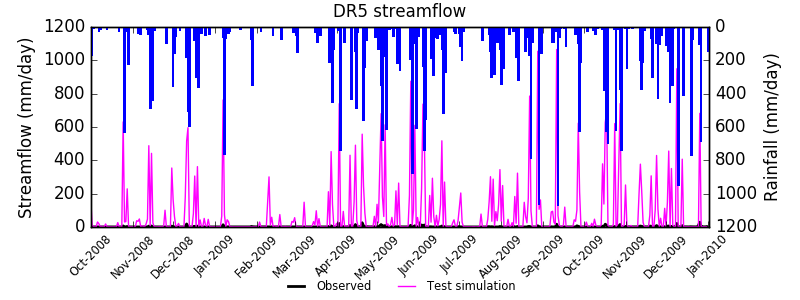

In [21]:
Image(filename=fname)